In [13]:
# numpy
import numpy as np
from numpy import unravel_index
print( 'Using numpy version %s' % np.__version__ )

# matplotlib and inline display in notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print( 'Using matplotlib version %s' % mpl.__version__ )

# matplotlib toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



import photutils

from astropy.io import fits

from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
# scipy
import scipy as scp
from scipy.ndimage import label
from scipy.interpolate import interp1d
from scipy.stats import sigmaclip, iqr
print( 'Using scipy version %s' % scp.__version__ )

# system
import glob, os

# astropy
import astropy as astro
from astropy.table import Table
from astropy.io import ascii, fits
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.cosmology import Planck15
from astropy.convolution import convolve_fft, Box2DKernel
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
print( 'Using astropy version %s' % astro.__version__ )

# photutils
import photutils as phot
from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnnulus, SkyEllipticalAperture, SkyCircularAperture, SkyCircularAnnulus
from photutils.detection import DAOStarFinder
print( 'Using photutils version %s' % phot.__version__ )

# text below modifies matplotlib settings so LaTeX can be used in plots
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

def centroid(im,region=None):
    """Compute centroid of image (M10/M00,M01/M00) (x,y), region: use this region to compute centroid"""
    if not(region is None):
        im=im[region[0]:region[1]] #region[2]:region[3]]
        offset=[region[0],region[2]]
    else: 
        offset=[0,0]
    m00=np.sum(im)
    m01=np.sum(np.sum(im,axis=1)*np.arange(im.shape[0]))
    m10=np.sum(np.sum(im,axis=0)*np.arange(im.shape[1]))
    return [m01/m00+offset[0], m10/m00+offset[1]]

Using numpy version 1.25.2
Using matplotlib version 3.6.0
Using scipy version 1.11.3
Using astropy version 6.0.1
Using photutils version 1.12.0


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_5181/3505464067.py:58: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnnulus, SkyEllipticalAperture, SkyCircularAperture, SkyCircularAnnulus
/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_5181/3505464067.py:58: DeprecationWarning: `photutils.EllipticalAnnulus` is a deprecated alias for `photutils.aperture.EllipticalAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAnnulus` to silence this warning.
  from photutils import EllipticalAperture, EllipticalAnnulus, aperture_photometry, CircularAnnulus, CircularAperture, SkyEllipticalAnnul

### load catalog

In [2]:
cat_f = ascii.read('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/10clumps_onGuocutout_photometrycode.csv')
print(cat_f.colnames)

['Unnamed: 0', 'Field', 'CANDELS_ID', 'z_1', 'RA_gal', 'DEC_gal', 'A', 'Clump_ID', 'dist_clump', 'flux_ratio', 'restuv_flux', 'RA_clump', 'DEC_clump', 'Raw_Flux_f125w_mjy', 'Background_Flux_f125w_mjy', 'Corrected_Flux_f125w_mjy', 'Raw_Flux_f160w_mjy', 'Background_Flux_f160w_mjy', 'Corrected_Flux_f160w_mjy', 'Raw_Flux_f275w_mjy', 'Background_Flux_f275w_mjy', 'Corrected_Flux_f275w_mjy', 'Raw_Flux_f435w_mjy', 'Background_Flux_f435w_mjy', 'Corrected_Flux_f435w_mjy', 'Raw_Flux_f606w_mjy', 'Background_Flux_f606w_mjy', 'Corrected_Flux_f606w_mjy', 'Raw_Flux_f775w_mjy', 'Background_Flux_f775w_mjy', 'Corrected_Flux_f775w_mjy', 'Raw_Flux_f850lp_mjy', 'Background_Flux_f850lp_mjy', 'Corrected_Flux_f850lp_mjy', 'Raw_Flux_f140w_mjy', 'Background_Flux_f140w_mjy', 'Corrected_Flux_f140w_mjy', 'Fld', 'F', 'ID', 'W', 'RAJ2000_1', 'DEJ2000_1', 'Q', 'mag', 'e_mag', 'r', 'e_r', 'n', 'e_n', 'q_lc', 'e_q', 'PA', 'e_PA', 'S_N', 'COSMOS', 'GOODS', 'recno', 'GroupID', 'GroupSize', 'Separation_1', 'norm_dist', 'Ga

### load CANDELS mosaic

In [7]:
f160w_hdu = fits.open('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/CANDELS-data/mosaics/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
print(f160w_hdu.info())

f160w_img = f160w_hdu[0].data
wcs = WCS(f160w_hdu[0].header)

header = f160w_hdu[0].header

f160w_hdu.close()

f160w_convert_factor = header['PHOTFNU']

f435w_hdu = fits.open('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/CANDELS-data/mosaics/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
print(f435w_hdu.info())

f435w_img = f435w_hdu[0].data
wcs_435 = WCS(f435w_hdu[0].header)

header_435 = f435w_hdu[0].header

f435w_hdu.close()

f435w_convert_factor = header_435['PHOTFLAM'] * header_435['PHOTPLAM'] ** 2 * 1e23 / (2.99792458e18)

kernel_435_hdu = fits.open('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/psfs/goodss_3dhst_v4.0_acs_psf/goodss_3dhst.v4.0.F435W_kernel.fits.gz')
kernel_435 = kernel_435_hdu[0].data
kernel_435_hdu.close()



Filename: /Users/neal/Documents/PhD/projects/SED-fitting/Clump/CANDELS-data/mosaics/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     151   (32400, 40500)   float32   
None
Filename: /Users/neal/Documents/PhD/projects/SED-fitting/Clump/CANDELS-data/mosaics/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (32400, 40500)   float32   


None


### create cutout

9024 2.141


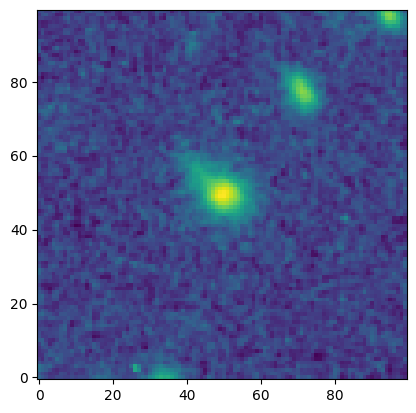

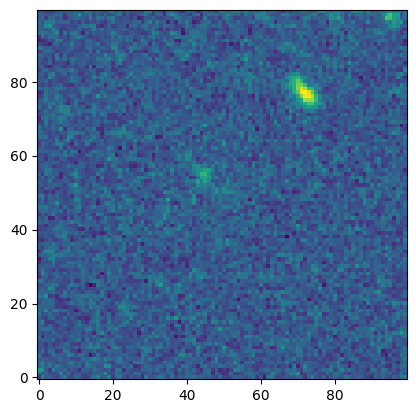

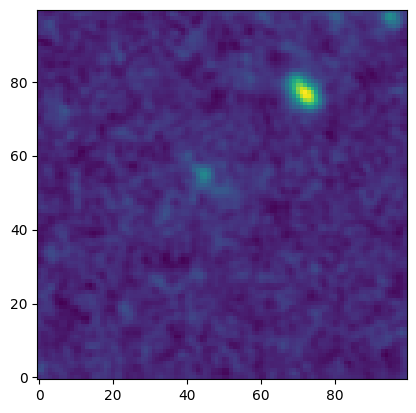

In [8]:
# idx = 7 (CANDELS ID 461) is a great example clump
# idx = 122 (CANDELS ID 16041) is a great example clump
# idx = 25 (CANDELS ID 2155) good multi-clump test case
# idx = 30 (CANDELS ID 2976) is a great example of two clumps
# idx = 145 (CANDELS ID 19186) is a great example containing faint clumps
# idx = 102 (CANDELS ID 10469) is a great example containing two clumps
# idx = 101 (CANDELS ID 10457) is a great example containing two clumps
# idx = 93 (CANDELS ID 9024) is a great example containing a faint clump
idx = 93

print(cat_f['CANDELS_ID'][idx], cat_f['z_1'][idx])

coords = SkyCoord(cat_f['RA_gal'][idx], cat_f['DEC_gal'][idx], unit='deg')

length= 100

cutout = Cutout2D(f160w_img, coords, (length, length), wcs=wcs)
cutout_435 = Cutout2D(f435w_img, coords, (length, length), wcs=wcs_435)

plt.imshow( np.arcsinh( cutout.data / 0.01 ), origin='lower')
plt.show()

plt.imshow( np.arcsinh( cutout_435.data / 0.01 ), origin='lower')
plt.show()

cutout_435_conv = convolve_fft(cutout_435.data, kernel_435)

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower')
plt.show()

cutout_wcs = cutout.wcs

print()



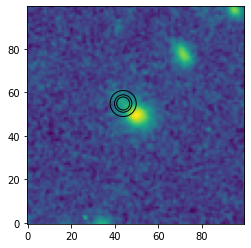

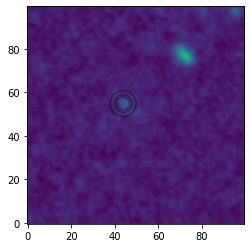

Flux according to Zahra's position: 0.024 uJy
Flux according to Guo+18: 0.072 uJy


In [287]:
x_offset = 0. # in pixels
y_offset = 0. # in pixels

target_coords = SkyCoord(cat_f['RA_clump'][idx] + (x_offset * 0.06/3600), cat_f['DEC_clump'][idx] + (y_offset * 0.06/3600), unit='deg')

target_aperture = SkyCircularAperture(positions=target_coords, r=0.18 * u.arcsec).to_pixel(wcs=cutout_wcs)
bckg_annulus = SkyCircularAnnulus(positions=target_coords, r_in=0.24 * u.arcsec, r_out=0.36 * u.arcsec).to_pixel(wcs=cutout_wcs)

plt.imshow( np.arcsinh( cutout.data / 0.01 ), origin='lower')

target_aperture.plot()
bckg_annulus.plot()

plt.show()

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower', vmax=2.5)

target_aperture.plot(alpha=0.5)
bckg_annulus.plot(alpha=0.5)

plt.show()

phot_table_target = aperture_photometry(data=cutout.data, apertures=target_aperture)
phot_table_bckg = aperture_photometry(data=cutout.data, apertures=bckg_annulus)

target_flux = phot_table_target['aperture_sum'][0]
bckg_flux = phot_table_bckg['aperture_sum'][0]

bckg_corr = target_aperture.area * bckg_flux / bckg_annulus.area

print( "Flux according to Zahra's position: %.3f uJy" % (1.5 * f160w_convert_factor * (target_flux - bckg_corr) * 1e6) )
print( "Flux according to Guo+18: %.3f uJy" % cat_f['F160W'][idx] )


### create mask centered on position from Zahra's code

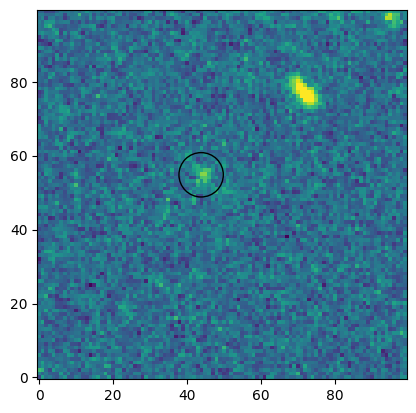

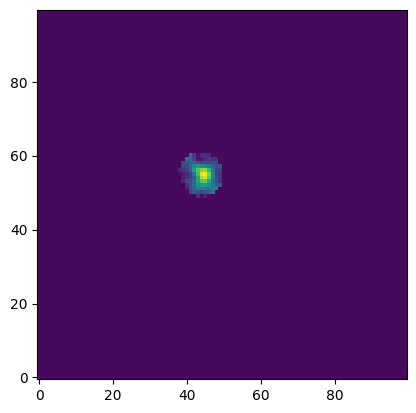

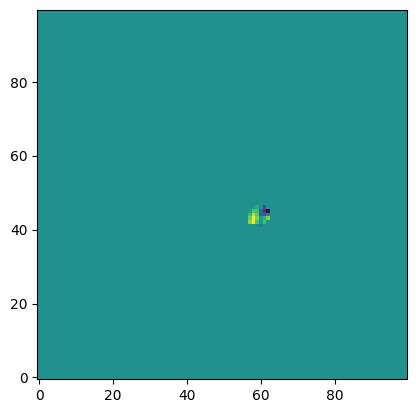

In [9]:

target_coords = SkyCoord(cat_f['RA_clump'][idx], cat_f['DEC_clump'][idx], unit='deg')

target_aperture = SkyCircularAperture(positions=target_coords, r=0.36 * u.arcsec).to_pixel(wcs=cutout_wcs)

plt.imshow( np.arcsinh( cutout_435.data / 0.01 ), origin='lower', vmax=1.5)

target_aperture.plot()

plt.show()

mask = target_aperture.to_mask(method='center')
mask_img = mask.to_image(cutout_435_conv.shape)

other_clump = CircularAperture(positions=(59.36, 43.70), r=0.18 / 0.06)
other_mask = other_clump.to_mask(method='center')
other_mask_img = other_mask.to_image(cutout_435_conv.shape)

plt.imshow( mask_img * cutout_435_conv, origin='lower')

plt.show()

plt.imshow( other_mask_img * cutout_435_conv, origin='lower')

plt.show()

### run centroid code on masked portion of image

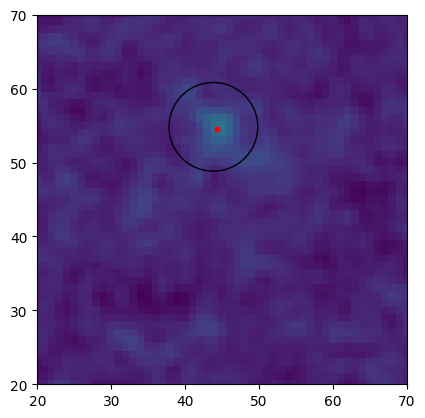

In [10]:
new_y, new_x = centroid(mask_img * cutout_435_conv)

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower', vmax=2)

plt.scatter(new_x, new_y, c='r', s=10)

target_aperture.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()


Flux according to UPDATED position: 0.668 uJy
Flux according to Guo+18: 0.761 uJy


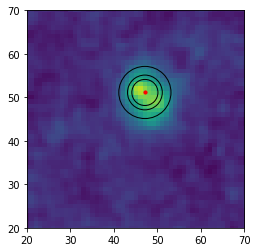

In [201]:
new_target_aperture = CircularAperture(positions=(new_x, new_y), r=0.18/0.06)
new_bckg_annulus = CircularAnnulus(positions=(new_x, new_y), r_in=0.24/0.06, r_out=0.36/0.06)

new_phot_table_target = aperture_photometry(data=cutout.data, apertures=new_target_aperture)
new_phot_table_bckg = aperture_photometry(data=cutout.data, apertures=new_bckg_annulus)

new_target_flux = new_phot_table_target['aperture_sum'][0]
new_bckg_flux = new_phot_table_bckg['aperture_sum'][0]

new_bckg_corr = new_target_aperture.area * new_bckg_flux / new_bckg_annulus.area

print( "Flux according to UPDATED position: %.3f uJy" % (1.5 * f160w_convert_factor * (new_target_flux - new_bckg_corr) * 1e6) )
print( "Flux according to Guo+18: %.3f uJy" % cat_f['F160W'][idx] )

plt.imshow( np.arcsinh( cutout_435_conv / 0.01 ), origin='lower', vmax=2)

plt.scatter(new_x, new_y, c='r', s=10)

new_target_aperture.plot()
new_bckg_annulus.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()

### create contrast image

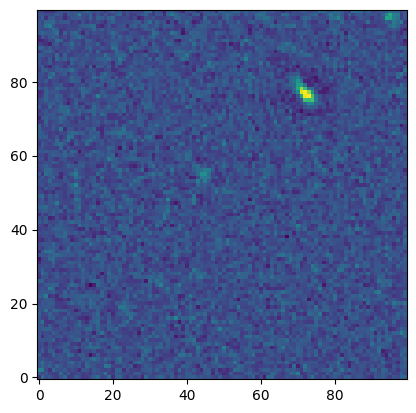

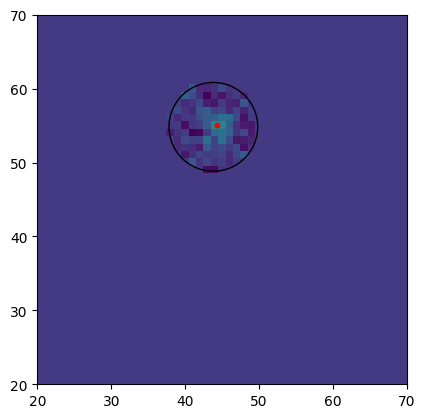

In [11]:
smooth_kernel = Box2DKernel(width=10.)

smooth_img = convolve_fft( cutout_435.data, smooth_kernel )

contrast_img = cutout_435.data - smooth_img

plt.imshow( contrast_img, origin='lower', vmax=0.03 )

plt.show()

new_y, new_x = centroid(mask_img * contrast_img)

plt.imshow( mask_img * contrast_img, origin='lower', vmax=0.03)

plt.scatter(new_x, new_y, c='r', s=10)

target_aperture.plot()

plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()


### searching for clumps using DAOFinder

 id     xcentroid         ycentroid      ...          peak         flux mag 
--- ----------------- ------------------ ... --------------------- ---- ----
  1 41.58324190634201  52.85403914428721 ... 0.0019949702624902158  inf -inf
  2 46.06017238997858 51.925916444986335 ... 0.0028118775740076382  inf -inf
  3 44.64800525009745  54.79236734932173 ... 0.0067763130655004835  inf -inf
  4 41.08237699323914   57.4643194467178 ...  0.002240523755356112  inf -inf 2
clump at: x = 44.64800525009745, y = 54.79236734932173


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


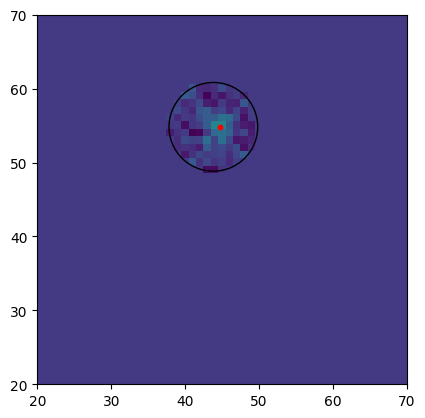

In [17]:
daofind = DAOStarFinder(fwhm=2., threshold=np.median(mask_img * cutout_435_conv))

sources = daofind((mask_img * cutout_435_conv))

print(sources, sources['peak'].argmax())

plt.imshow( mask_img * contrast_img, origin='lower', vmax=0.03)

max_bright_idx = sources['peak'].argmax()

plt.scatter(sources['xcentroid'][max_bright_idx], sources['ycentroid'][max_bright_idx], c='r', s=10)

#plt.scatter( 59.36, 43.70 )

target_aperture.plot()

x_brightest = sources['xcentroid'][max_bright_idx]
y_brightest = sources['ycentroid'][max_bright_idx]

# Print coordinates
print(f"clump at: x = {x_brightest}, y = {y_brightest}")
plt.xlim(20, 70)
plt.ylim(20, 70)

plt.show()


# Make this work on a catalog:

In [24]:
cat_f= pd.read_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/10clumps_onGuocutout_photometrycode.csv')

In [27]:

from astropy.visualization import simple_norm

# Initialize lists to store the new x and y coordinates
new_xs = []
new_ys = []

# Iterate over the DataFrame
for idx, clump in cat_f.iterrows():
    coords = SkyCoord(clump['RA_gal'], clump['DEC_gal'], unit='deg')
    
    # Perform the cutouts
    cutout = Cutout2D(f160w_img, coords, (length, length), wcs=wcs)
    cutout_435 = Cutout2D(f435w_img, coords, (length, length), wcs=wcs_435)
    
    # Convolve the 435 cutout
    cutout_435_conv = convolve_fft(cutout_435.data, kernel_435)
    
    # Find sources in the 435 cutout
    daofind = DAOStarFinder(fwhm=2., threshold=np.median(cutout_435_conv))
    sources = daofind(cutout_435_conv)
    
    # Ensure sources are found
    if sources is not None:
        max_bright_idx = sources['peak'].argmax()
        new_x = sources['xcentroid'][max_bright_idx]
        new_y = sources['ycentroid'][max_bright_idx]
    else:
        # If no sources are found,  choose to keep the original coordinates
        # or set them to NaN or some sentinel value
        new_x = np.nan
        new_y = np.nan

    # Append the new coordinates to the lists
    new_xs.append(new_x)
    new_ys.append(new_y)

# Add the new x and y coordinates to the DataFrame
cat_f['new_x'] = new_xs
cat_f['new_y'] = new_ys

# Save the dataframe 
cat_f.to_csv('10clummp_added x andy_clump_catalog.csv', index=False)


/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:476: RuntimeWarning: divide by zero encountered in divide
  return (self.data_peak - data_mean) / self.convdata_peak
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:476: RuntimeWarning: invalid value encountered in divide
  return (self.data_peak - data_mean) / self.convdata_peak
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:476: RuntimeWarning: divide by zero encountered in divide
  return (self.data_peak - data_mean) / self.convdata_peak
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:476: RuntimeWarning: invalid value encountered in divide
  return (self.data_peak - data_mean) / self.convdata_peak
/Users/neal/anaconda3/lib/python3.10/site-packages/photutils/detection/daofinder.py:476: RuntimeWarning: divide by zero encountered in divide
  return (self.data_peak - data_mean) / self.convdata_pe

# Adding Photometry as the second block:

In [21]:
def automated_photometry(clumps, wcs, science_image,phot_zp, mask_aperture_size=0.24, annulus_inner=0.24, annulus_outer=0.36):
    results = []

    # Convert the science image to a floating point array if not already
    science_image = np.array(science_image, dtype=float)

    # Iterates over each clump
    for index, target_clump in clumps.iterrows():
        # Check if the target clump has valid coordinates. Skips processing if the DEC value of the clump is set to a (-99.0), 
        # which indicates invalid or missing data.
        if target_clump['DEC_clump'] == -99.0:
            print(f"Skipping clump due to invalid coordinates: {target_clump['CANDELS_ID']}, {target_clump['Clump_ID']}")
            continue

        # Converts the RA and DEC of the target clump to a SkyCoord object
        target_coords = SkyCoord(ra=target_clump['RA_clump']*u.degree, dec=target_clump['DEC_clump']*u.degree)

        # Creates a copy of the original image to mask out other clumps, 
        # so that they do not affect the photometry of the target clump.
        science_image_masked = np.copy(science_image)

        # Mask other clumps only if more than one clump is present, (by setting their pixel values to 0)
        if len(clumps) > 1:
            for _, other_clump in clumps.drop(index).iterrows():
                other_coords = SkyCoord(ra=other_clump['RA_clump']*u.degree, dec=other_clump['DEC_clump']*u.degree)
                mask_aperture = SkyCircularAperture(other_coords, r=mask_aperture_size*u.arcsec).to_pixel(wcs)
                mask = mask_aperture.to_mask(method='center')
                # Generates slices for numpy array indexing using the bounding box of the mask.
                bbox_slices = (slice(mask.bbox.iymin, mask.bbox.iymax), slice(mask.bbox.ixmin, mask.bbox.ixmax))
                # Accesses the section of the image to mask out.
                science_image_masked_section = science_image_masked[bbox_slices]
                mask_data = mask.data.astype(bool)

                mask_data = mask_data[
                :min(mask_data.shape[0], science_image_masked_section.shape[0]),
                :min(mask_data.shape[1], science_image_masked_section.shape[1])
                ]
                # Applies the mask to the image 
                science_image_masked_section[mask_data] = 0
                science_image_masked[bbox_slices] = science_image_masked_section
               
           
            # #plot mask
            # plt.imshow(science_image_masked)
            # plt.show()


        # Perform photometry on the target clump
        target_aperture = SkyCircularAperture(target_coords, r=0.18*u.arcsec).to_pixel(wcs)
        photometry = aperture_photometry(science_image_masked, target_aperture)

        # Check if photometry result is unexpected!(We get this since some images in some bands are just black)
        if photometry['aperture_sum'][0] == 0:
            print(f"Zero flux detected for clump: {target_clump['CANDELS_ID']}, {target_clump['Clump_ID']}")
            

        # Background subtraction
        annulus_aperture = SkyCircularAnnulus(target_coords, r_in=annulus_inner*u.arcsec, r_out=annulus_outer*u.arcsec).to_pixel(wcs)
        background = aperture_photometry(science_image_masked, annulus_aperture)
        area_annulus = annulus_aperture.area
        # Calculates the average background flux per pixel within the annulus
        background_per_pixel = background['aperture_sum'][0] / area_annulus
        # Scales the average background to the aperture size
        total_background_light = background_per_pixel * target_aperture.area
        corrected_flux = 1.5 *(photometry['aperture_sum'][0] - total_background_light) # aperture correction

        # wrong_corrected_flux = (1.5 *(photometry['aperture_sum'][0])) - total_background_light

        raw_flux_mjy = (photometry['aperture_sum'][0] * phot_zp) * 1e6  # Convert from Jy to μJy
        background_flux_mjy = (total_background_light * phot_zp) * 1e6
        corrected_flux_mjy = (corrected_flux * phot_zp) * 1e6
        # wrong_corrected_flux_mjy =  (wrong_corrected_flux * phot_zp) * 1e6

        # Appends the results for this clump 
        results.append({
            'CANDELS_ID': target_clump['CANDELS_ID'],
            'Clump_ID': target_clump['Clump_ID'],
            'Raw_Flux_mjy': raw_flux_mjy,
            'Background_Flux_mjy': background_flux_mjy,
            'Corrected_Flux_mjy': corrected_flux_mjy,
            # 'wrong_corrected_flux_mjy' :wrong_corrected_flux_mjy
        })
    # Converts the results list into a DataFrame
    return pd.DataFrame(results)


In [ ]:
import os

# List of bands 
bands = [ 'f160', 'f606', 'f850']

# Initialize a dictionary to hold the WCS objects and science image data for each band
wcs_dict = {band: {} for band in bands}
image_data_dict = {band: {} for band in bands}
phot_zp_dict ={band: {} for band in bands}



# Populate the dictionaries with WCS and image data for each band and galaxy
for candels_id in clump_catalog['CANDELS_ID'].unique()[:10]:

    # if candels_id == 40:
    #     pass
    # else:
    #     continue


    
    for band in bands:
        fits_path = f'/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts-Guo/goodss_{candels_id}_{band}.fits'
        # print(f"Looking for FITS file at path: {fits_path}")  # Print the expected file path
        
        # Check if the FITS file exists
        if os.path.exists(fits_path):
          
            with fits.open(fits_path) as hdul:
                wcs_dict[band][candels_id] = WCS(hdul[0].header)
                image_data_dict[band][candels_id] = hdul[0].data
       
      

                # Read the conversion factor from the header
                if 'PHOT_ZP' in hdul[0].header:
                    phot_zp_dict[band][candels_id] = hdul[0].header['PHOT_ZP']
                else:
                    print(f"PHOT_ZP keyword not found in header of {fits_path}. Using default value.")
                   
                    phot_zp_dict[(candels_id, band)] = phot_zp

# Perform photometry for each band and galaxy, and add results to the catalog
for candels_id in clump_catalog['CANDELS_ID'].unique()[:10]:
    galaxy_clumps = clump_catalog[(clump_catalog['CANDELS_ID'] == candels_id) & (clump_catalog['DEC_clump'] <= 90) & (clump_catalog['DEC_clump'] >= -90)].copy()
    
    for band in bands:
        # Check if the galaxy has data in this band
        if candels_id in wcs_dict[band] and candels_id in image_data_dict[band]:
            wcs = wcs_dict[band][candels_id]
            science_image = image_data_dict[band][candels_id]
            phot_zp = phot_zp_dict[band][candels_id]  # Get the photometric zero point for the current band and galaxy

            # Check if the science image is not empty or  black
            if not np.all(science_image == 0):
                photometry_results = automated_photometry(galaxy_clumps, wcs, science_image,phot_zp)
                
                
                #  Update the original clump_catalog with the converted flux results
                for index, row in photometry_results.iterrows():
                    mask = (clump_catalog['CANDELS_ID'] == row['CANDELS_ID']) & (clump_catalog['Clump_ID'] == row['Clump_ID'])
                    clump_catalog.loc[mask, f'Raw_Flux_{band}_mjy'] = row['Raw_Flux_mjy']
                    clump_catalog.loc[mask, f'Background_Flux_{band}_mjy'] = row['Background_Flux_mjy']
                    clump_catalog.loc[mask, f'Corrected_Flux_{band}_mjy'] = row['Corrected_Flux_mjy']
                    # clump_catalog.loc[mask, f'wrong_corrected_flux_{band}_mjy'] = row['wrong_corrected_flux_mjy']


# Save the updated clump catalog with photometry results!!! chNge!!!
clump_catalog.to_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/compatible_on10clumps_onGuocutout_photometrycode.csv', index=False)
